# Projet Air Paradis - Anticipation des Bad Buzz sur les Réseaux Sociaux

## Contexte
Nous sommes engagés par Air Paradis, une compagnie aérienne qui souhaite développer un produit IA capable de prédire le sentiment associé à un tweet pour anticiper les bad buzz sur les réseaux sociaux. Ce notebook documente notre démarche de développement, de la conception des modèles jusqu'à leur déploiement.


In [1]:
import os
# Configurer l'environnement pour utiliser `tf_keras`
os.environ['TF_USE_LEGACY_KERAS'] = 'True'

In [2]:
# Standard libraries
import os
import re
from io import BytesIO
from concurrent.futures import ThreadPoolExecutor, as_completed

import json

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Machine learning and deep learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

import torch
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import  ModelCheckpoint
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall

from transformers import BertTokenizer, BertModel, BertConfig, TFBertForSequenceClassification

import mlflow
import mlflow.sklearn

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import fasttext
from langdetect import detect, DetectorFactory, LangDetectException

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# File and web handling
import requests
import zipfile
from urllib.request import urlretrieve
from zipfile import ZipFile

# Utilities
import ftfy
import ast
from tqdm import tqdm

# Machine learning models from gensim
from gensim.models import KeyedVectors

import pickle

import joblib  # Pour la sauvegarde du modèle



/opt/anaconda3/envs/bert_sentiment_analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Transformers is only compatible with Keras 2, but you have explicitly set `TF_USE_LEGACY_KERAS` to `0`. This may result in unexpected behaviour or errors if Keras 3 objects are passed to Transformers models.


In [3]:
# Simple test operation
tf.constant([1.0, 2.0, 3.0]) + tf.constant([1.0, 2.0, 3.0])
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.16.1
Num GPUs Available:  1


2024-06-10 07:39:22.295818: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-06-10 07:39:22.295842: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-10 07:39:22.295846: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-10 07:39:22.295866: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-10 07:39:22.295889: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Configuration initiale pour MLFLOW

In [4]:
# Configuration du tracking URI pour MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5003")

### Arret du notebook si le fichier traité existe deja pour passer a la suite

In [23]:
# Chemin du fichier
file_path = '../data/data_english_only.csv'

# Vérifier si le fichier existe
if os.path.exists(file_path):
    # Charger le DataFrame si le fichier existe
    data_english_only = pd.read_csv(file_path)
    display(data_english_only.head())  # Afficher les premières lignes pour vérifier le chargement
    # Stopper l'exécution du notebook
    print("Le fichier existe déjà. Chargement effectué. Arrêt du notebook.")
else:
    print("Le fichier n'existe pas. Continuez l'exécution du notebook.")

,target,date,user,text,length,language,tokens,text_lemmatized,text_stemmed
0,0,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,a thats a bummer you shoulda got david car...,19,en,"['thats', 'bummer', 'shoulda', 'got', 'david',...","['thats', 'bummer', 'shoulda', 'got', 'david',...","['that', 'bummer', 'shoulda', 'got', 'david', ..."
1,0,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he cant update his facebook by t...,21,en,"['upset', 'cant', 'update', 'facebook', 'texti...","['upset', 'cant', 'update', 'facebook', 'texti...","['upset', 'cant', 'updat', 'facebook', 'text',..."
2,0,Mon Apr 06 22:19:53 PDT 2009,mattycus,i dived many times for the ball managed to sa...,18,en,"['dived', 'many', 'times', 'ball', 'managed', ...","['dived', 'many', 'time', 'ball', 'managed', '...","['dive', 'mani', 'time', 'ball', 'manag', 'sav..."
3,0,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire,10,en,"['whole', 'body', 'feels', 'itchy', 'like', 'f...","['whole', 'body', 'feel', 'itchy', 'like', 'fi...","['whole', 'bodi', 'feel', 'itchi', 'like', 'fi..."
4,0,Mon Apr 06 22:19:57 PDT 2009,Karoli,no its not behaving at all im mad why am i he...,21,en,"['behaving', 'im', 'mad', 'cant', 'see']","['behaving', 'im', 'mad', 'cant', 'see']","['behav', 'im', 'mad', 'cant', 'see']"


Le fichier existe déjà. Chargement effectué. Arrêt du notebook.


## Collecte et Exploration des Données

Nous utiliserons des données Open Source pour entraîner nos modèles. Cette section se concentre sur l'acquisition, l'exploration et la préparation initiale des données pour nos modèles de sentiment analysis.

About Columns:¶

    target: the polarity of the tweet (0 = negative, 4 = positive)

    ids: The id of the tweet ( 2087)

    date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

    flag: The query (lyx) Column represents that If there is no query, then this value is NO_QUERY.

    user: The user that tweeted (robotickilldozr)

    text: The text of the tweet (Lyx is cool) ## Acknowledgements:

    The official link regarding the dataset with resources about how it was generated is here The official paper detailing the approach is here

    Citation: Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12. ## Aims and Objectives:


In [24]:
# Paramètres configurables
data_directory = "../data/sources"  # Répertoire pour stocker les données
zip_file_url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip"  # URL du fichier ZIP à télécharger
zip_file_name = "sentiment140.zip"  # Nom du fichier ZIP à télécharger

# Vérifiez si le répertoire et les données existent déjà pour éviter le téléchargement et l'extraction répétés
if not os.path.exists(os.path.join(data_directory, zip_file_name.replace('.zip', ''))):
    # Création du répertoire s'il n'existe pas
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Téléchargement du fichier ZIP
    response = requests.get(zip_file_url)
    zip_content = BytesIO(response.content)

    # Extraction du contenu du fichier ZIP
    with zipfile.ZipFile(zip_content, 'r') as zip_ref:
        zip_ref.extractall(data_directory)
else:
    print("Les données sont déjà téléchargées et extraites.")

# Recherche du fichier CSV dans le répertoire extrait
data_path = None
for root, dirs, files in os.walk(data_directory):
    for file in files:
        if file.endswith('.csv'):
            data_path = os.path.join(root, file)
            break

if data_path:
    # Chargement et affichage des premières lignes du fichier CSV pour vérifier
    data = pd.read_csv(data_path, encoding="latin_1",  names=['target', 'ids', 'date', 'flag', 'user', 'text'])
    # Supposons que la colonne contenant le texte est la 5ème colonne
    data['text'] = data['text'].apply(ftfy.fix_text)

    # Affichage des informations sur les données
    display(data.info())
    display(data.describe(include='all'))
    display(data.head())
else:
    print("Aucun fichier CSV trouvé dans le répertoire extrait.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


None

,target,ids,date,flag,user,text
count,1.600000e+06,1.600000e+06,1600000,1600000,1600000,1600000
unique,NaN,NaN,774363,1,659775,1581466
top,NaN,NaN,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,NaN,NaN,20,1600000,549,210
mean,2.000000e+00,1.998818e+09,NaN,NaN,NaN,NaN
std,2.000001e+00,1.935761e+08,NaN,NaN,NaN,NaN
min,0.000000e+00,1.467810e+09,NaN,NaN,NaN,NaN
25%,0.000000e+00,1.956916e+09,NaN,NaN,NaN,NaN
50%,2.000000e+00,2.002102e+09,NaN,NaN,NaN,NaN
75%,4.000000e+00,2.177059e+09,NaN,NaN,NaN,NaN


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Prétraitement des Données

Avant de former nos modèles, il est crucial de nettoyer et de prétraiter nos données. Cette étape inclut la tokenisation, la lemmatisation, la suppression des stop-words, etc.


In [25]:
# Analyse des doublons
print("Nombre de doublons avant suppression :", data.duplicated(subset=['date', 'user','text']).sum())
doublons = data[data.duplicated()]


Nombre de doublons avant suppression : 1873


In [26]:
# supression des colonnes inutiles
data = data.drop(['ids','flag'], axis=1)
# Suppression des doublons
data_clean = data.drop_duplicates(subset=['date', 'user', 'text']).copy()


In [27]:
# Re-codage de la colonne 'target' de 0 et 4 à 0 et 1
data_clean['target'] = data_clean['target'].map({0: 0, 4: 1})

# Vérification des premières lignes pour s'assurer que les modifications sont correctes
display(data_clean.head())

,target,date,user,text
0,0,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,0,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,0,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."


## Distribution des Sentiments
Un graphique à barres pour visualiser la distribution des sentiments dans le dataset.

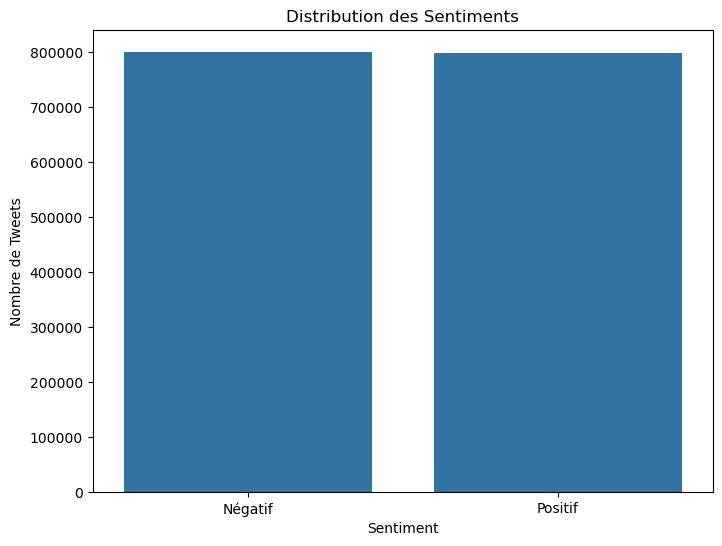

In [28]:
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=data_clean)
plt.title('Distribution des Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Nombre de Tweets')
plt.xticks(ticks=[0, 1], labels=['Négatif', 'Positif'])
plt.show()


## Longueur des Tweets
Un histogramme pour explorer la longueur des tweets et voir s'il existe des différences significatives entre les tweets positifs et négatifs.

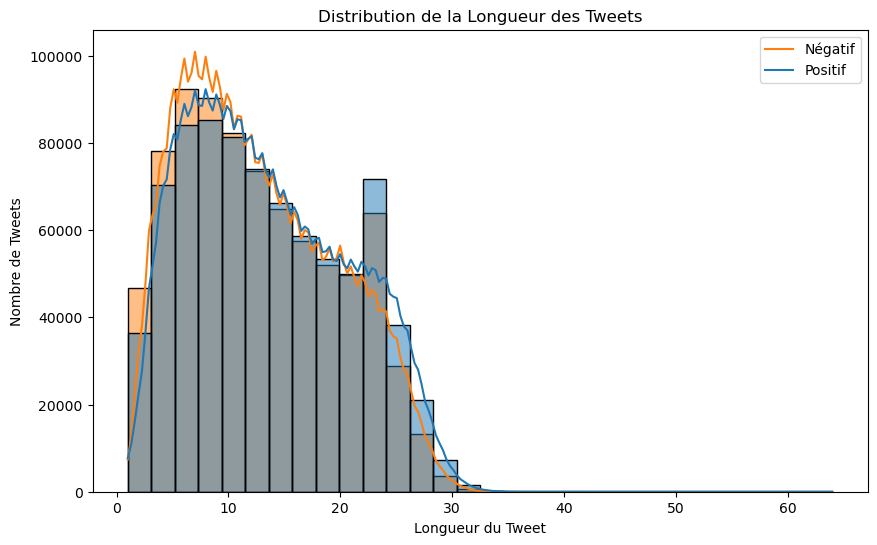

In [29]:
# Calcul de la longueur de chaque tweet
data_clean['length'] = data_clean['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(data=data_clean, x='length', hue='target', bins=30, kde=True)
plt.title('Distribution de la Longueur des Tweets')
plt.xlabel('Longueur du Tweet')
plt.ylabel('Nombre de Tweets')
plt.legend(labels=['Négatif', 'Positif'])
plt.show()


## Nuages de Mots (Word Clouds)
Les nuages de mots pour les tweets positifs et négatifs peuvent aider à visualiser les mots les plus fréquents associés à chaque sentiment.

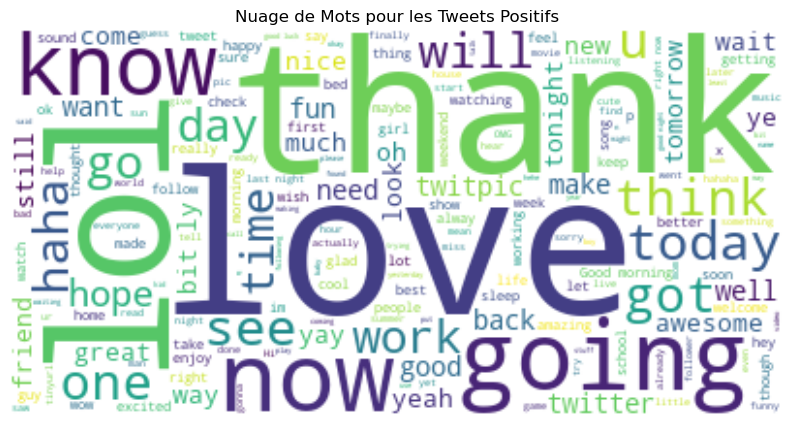

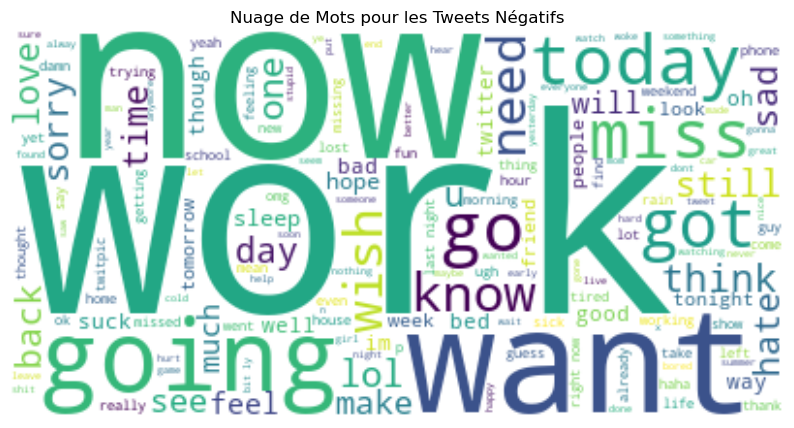

In [30]:
# Texte pour les tweets positifs et négatifs
text_positif = " ".join(tweet for tweet in data_clean[data_clean['target'] == 1]['text'])
text_negatif = " ".join(tweet for tweet in data_clean[data_clean['target'] == 0]['text'])

# Génération du nuage de mots pour les tweets positifs
wordcloud_pos = WordCloud(background_color='white').generate(text_positif)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Nuage de Mots pour les Tweets Positifs')
plt.axis('off')
plt.show()

# Génération du nuage de mots pour les tweets négatifs
wordcloud_neg = WordCloud(background_color='white').generate(text_negatif)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Nuage de Mots pour les Tweets Négatifs')
plt.axis('off')
plt.show()

In [31]:
# Sauvegarde du DataFrame nettoyé dans un fichier CSV
data_clean.to_csv('../data/data_clean.csv', index=False)

In [32]:
# Rechargement du DataFrame à partir du fichier CSV sauvegardé
data_reloaded = pd.read_csv('../data/data_clean.csv')

# Vérification des premières lignes pour s'assurer que le chargement a fonctionné correctement
display(data_reloaded.head())

,target,date,user,text,length
0,0,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",19
1,0,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...,21
2,0,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...,18
3,0,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire,10
4,0,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all....",21


## Détection de la langue
La détection de la langue permettra de mieux cibler le nettoyage

In [33]:
# Fonction pour télécharger le modèle FastText s'il n'existe pas
def download_fasttext_model(model_url, model_path):
    if not os.path.exists(model_path):
        print(f"Modèle FastText non trouvé à {model_path}. Téléchargement en cours...")
        response = requests.get(model_url)
        with open(model_path, 'wb') as model_file:
            model_file.write(response.content)
        print("Téléchargement terminé.")

# URL du modèle FastText et chemin local pour le sauvegarder
model_url = "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin"
model_path = "lid.176.bin"

# Téléchargez le modèle FastText si nécessaire
download_fasttext_model(model_url, model_path)

# Chargement du modèle pré-entraîné FastText pour la détection de la langue
model = fasttext.load_model(model_path)

def detect_language_fasttext(text):
    text = str(text).replace('\n', ' ')
    predictions = model.predict([text], k=1)
    return predictions[0][0][0].replace('__label__', '')

def detect_languages_parallel(texts, num_threads):
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        future_to_text = {executor.submit(detect_language_fasttext, text): text for text in texts}
        results = []
        for future in as_completed(future_to_text):
            result = future.result()
            results.append(result)
        return results

# Application de la détection de langue en parallèle
num_threads = 10  # Ajustez en fonction de votre environnement
languages = detect_languages_parallel(data_reloaded['text'], num_threads)

# Stockage du résultat dans une nouvelle colonne 'language'
data_reloaded['language'] = languages

Modèle FastText non trouvé à lid.176.bin. Téléchargement en cours...
Téléchargement terminé.


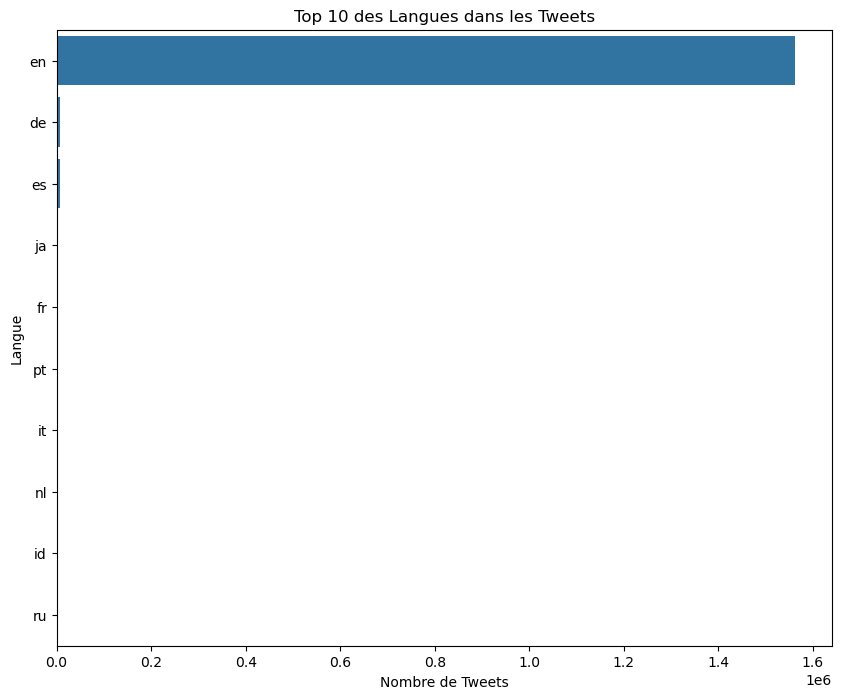

In [34]:
plt.figure(figsize=(10, 8))
top_languages = data_reloaded['language'].value_counts().head(10)
sns.countplot(y='language', data=data_reloaded, order=top_languages.index)
plt.title('Top 10 des Langues dans les Tweets')
plt.xlabel('Nombre de Tweets')
plt.ylabel('Langue')
plt.show()

In [35]:
# Filtrer le DataFrame pour ne garder que les tweets en anglais
data_english_only = data_reloaded[data_reloaded['language'] == 'en']

## Nettoyage du texte
Le nettoyage du texte impliquera la suppression des éléments inutiles comme les URLs, les mentions (@), les hashtags (#), les caractères spéciaux et les chiffres. Nous allons également convertir le texte en minuscules pour uniformiser les données.

In [36]:
def clean_text(text):
    text = text.lower()  # Convertir en minuscules
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Supprimer les URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Supprimer les mentions et hashtags
    text = re.sub(r'\d+', '', text)  # Supprimer les chiffres
    text = re.sub(r'[^\w\s]', '', text)  # Supprimer la ponctuation
    return text

# Application de la fonction de nettoyage à chaque tweet
data_english_only.loc[:, 'text'] = data_english_only.loc[:, 'text'].apply(clean_text)

In [37]:
print(data_english_only['text'].head())

0       a thats a bummer  you shoulda got david car...
1    is upset that he cant update his facebook by t...
2     i dived many times for the ball managed to sa...
3      my whole body feels itchy and like its on fire 
4     no its not behaving at all im mad why am i he...
Name: text, dtype: object


## Tokenisation
La tokenisation consiste à diviser le texte en mots ou tokens. Cela peut être réalisé en utilisant des bibliothèques comme NLTK ou directement avec des méthodes pandas.

In [38]:
# Vérifier si 'punkt' est déjà téléchargé
if 'punkt' in nltk.data.path:
    print("'punkt' tokenizer model is already downloaded.")
else:
    nltk.download('punkt')
    print("'punkt' tokenizer model has been downloaded.")

# Application de la tokenisation à chaque tweet
# Tokenisation des tweets en utilisant .loc pour éviter les avertissements SettingWithCopyWarning
data_english_only['tokens'] = data_english_only['text'].apply(word_tokenize)

'punkt' tokenizer model has been downloaded.


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/cyrilleguillaud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/var/folders/py/py1lxp896ql9s334cbk9y9s80000gn/T/ipykernel_39255/3801561179.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_english_only['tokens'] = data_english_only['text'].apply(word_tokenize)


In [39]:
print(data_english_only['tokens'].head())

0    [a, thats, a, bummer, you, shoulda, got, david...
1    [is, upset, that, he, cant, update, his, faceb...
2    [i, dived, many, times, for, the, ball, manage...
3    [my, whole, body, feels, itchy, and, like, its...
4    [no, its, not, behaving, at, all, im, mad, why...
Name: tokens, dtype: object


## Suppression des stop-words
Les stop-words sont des mots très communs qui sont généralement ignorés dans le traitement du langage naturel car ils n'apportent pas de valeur significative pour l'analyse. Nous allons les supprimer.

In [40]:
# Vérifier si 'stopwords' est déjà téléchargé
if 'stopwords' in nltk.data.path:
    print("'stopwords' tokenizer model is already downloaded.")
else:
    nltk.download('stopwords')
    print("'stopwords' tokenizer model has been downloaded.")

stop_words = set(stopwords.words('english'))

# Fonction pour supprimer les stop-words
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Application de la suppression des stop-words à chaque tweet
data_english_only['tokens'] = data_english_only['tokens'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cyrilleguillaud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'stopwords' tokenizer model has been downloaded.


/var/folders/py/py1lxp896ql9s334cbk9y9s80000gn/T/ipykernel_39255/2610908634.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_english_only['tokens'] = data_english_only['tokens'].apply(remove_stopwords)


In [41]:
print(data_english_only['tokens'].head())

0    [thats, bummer, shoulda, got, david, carr, thi...
1    [upset, cant, update, facebook, texting, might...
2    [dived, many, times, ball, managed, save, rest...
3              [whole, body, feels, itchy, like, fire]
4                       [behaving, im, mad, cant, see]
Name: tokens, dtype: object


## Lemmatisation et stemming
La lemmatisation permet de ramener les mots à leur forme de base. Par exemple, "running" devient "run". Cela peut aider à réduire la complexité des données textuelles.
Le stemming va supprimer le sufixe ou le prefixe simplement.

In [42]:
# Vérifier si 'wordnet' est déjà téléchargé
if 'wordnet' not in nltk.data.path:
    nltk.download('wordnet')
    print("'wordnet' tokenizer model has been downloaded.")
else:
    print("'wordnet' tokenizer model is already downloaded.")

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Fonction pour la lemmatisation
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Fonction pour le stemming
def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

# Assurez-vous que data_english_only est un DataFrame propre et non une vue d'un autre DataFrame
data_english_only = data_english_only.copy()

# Application de la lemmatisation à chaque tweet
data_english_only.loc[:, 'text_lemmatized'] = data_english_only['tokens'].apply(lemmatize_tokens)

# Application de la stemmatisation à chaque tweet
data_english_only.loc[:, 'text_stemmed'] = data_english_only['tokens'].apply(stem_tokens)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/cyrilleguillaud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


'wordnet' tokenizer model has been downloaded.


In [43]:
print(data_english_only['text_lemmatized'].head())
print(data_english_only['text_stemmed'].head())

0    [thats, bummer, shoulda, got, david, carr, thi...
1    [upset, cant, update, facebook, texting, might...
2    [dived, many, time, ball, managed, save, rest,...
3               [whole, body, feel, itchy, like, fire]
4                       [behaving, im, mad, cant, see]
Name: text_lemmatized, dtype: object
0    [that, bummer, shoulda, got, david, carr, thir...
1    [upset, cant, updat, facebook, text, might, cr...
2    [dive, mani, time, ball, manag, save, rest, go...
3               [whole, bodi, feel, itchi, like, fire]
4                          [behav, im, mad, cant, see]
Name: text_stemmed, dtype: object


In [44]:
# Sauvegarde du DataFrame nettoyé dans un fichier CSV
data_english_only.to_csv('../data/data_english_only.csv', index=False)

### Etape du notebook aprés traitement

In [5]:
# Rechargement du DataFrame
data_english_only = pd.read_csv('../data/data_english_only.csv')

# Conversion des chaînes de caractères représentant des listes en listes réelles
data_english_only['text_lemmatized'] = data_english_only['text_lemmatized'].apply(ast.literal_eval)
data_english_only['text_stemmed'] = data_english_only['text_stemmed'].apply(ast.literal_eval)

# Vérification
print(data_english_only['text_lemmatized'].head())
print(data_english_only['text_stemmed'].head())

0    [thats, bummer, shoulda, got, david, carr, thi...
1    [upset, cant, update, facebook, texting, might...
2    [dived, many, time, ball, managed, save, rest,...
3               [whole, body, feel, itchy, like, fire]
4                       [behaving, im, mad, cant, see]
Name: text_lemmatized, dtype: object
0    [that, bummer, shoulda, got, david, carr, thir...
1    [upset, cant, updat, facebook, text, might, cr...
2    [dive, mani, time, ball, manag, save, rest, go...
3               [whole, bodi, feel, itchi, like, fire]
4                          [behav, im, mad, cant, see]
Name: text_stemmed, dtype: object


## Modélisation

### Approche Modèle sur Mesure Simple
Dans cette section, nous développerons un modèle de régression logistique comme approche simple pour prédire le sentiment des tweets.


In [60]:
#Cette fonction prend en charge l'entraînement d'un modèle donné et son évaluation sur un ensemble de test,
# en affichant des métriques clés comme l'accuracy, la précision, le rappel et le score F1.
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Entraînement du modèle
    model.fit(X_train, y_train)

    # Prédiction sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Affichage du rapport de classification
    print(classification_report(y_test, y_pred))

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    # Retourner les métriques pour éventuellement les logger dans MLFlow
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

from sklearn.model_selection import GridSearchCV

#Cette fonction simplifie la recherche d'hyperparamètres pour n'importe quel modèle, en utilisant GridSearchCV
def grid_search(model, param_grid, X_train, y_train, scoring='accuracy', cv=5, stratify=None):
    if stratify is not None:
        cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Affichage des meilleurs paramètres
    print("Meilleurs paramètres : ", grid_search.best_params_)

    return grid_search.best_estimator_
# Fonction pour enregistrer systématiquement les modèles et les métriques de MLFlow.
def log_model_metrics(model, model_name, metrics, params=None):
    with mlflow.start_run(run_name=model_name):
        # Enregistrement des paramètres du modèle, s'ils existent
        if params:
            mlflow.log_params(params)

        # Enregistrement des métriques
        mlflow.log_metrics(metrics)

        # Enregistrement du modèle
        mlflow.sklearn.log_model(model, model_name)

def plot_roc_curve(model, X_test, y_test):
    # Prédire les probabilités pour l'ensemble de test.
    # Utilise decision_function ou predict_proba en fonction du modèle
    if hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        y_score = model.predict_proba(X_test)[:, 1]

    # Calculer les taux de vrais positifs et de faux positifs
    fpr, tpr, _ = roc_curve(y_test, y_score)

    # Calculer l'aire sous la courbe ROC
    roc_auc = auc(fpr, tpr)

    # Affichage de la courbe ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


In [47]:
print(data_english_only['text_lemmatized'].head())

0    [thats, bummer, shoulda, got, david, carr, thi...
1    [upset, cant, update, facebook, texting, might...
2    [dived, many, time, ball, managed, save, rest,...
3               [whole, body, feel, itchy, like, fire]
4                       [behaving, im, mad, cant, see]
Name: text_lemmatized, dtype: object


In [48]:
data_english_only['text_lemmatized'] = data_english_only['text_lemmatized'].apply(lambda tokens: ' '.join(tokens))
if not any(data_english_only['text_lemmatized'].str.strip()):
    raise ValueError("Après la prétraitement, il ne reste aucun mot dans le texte.")

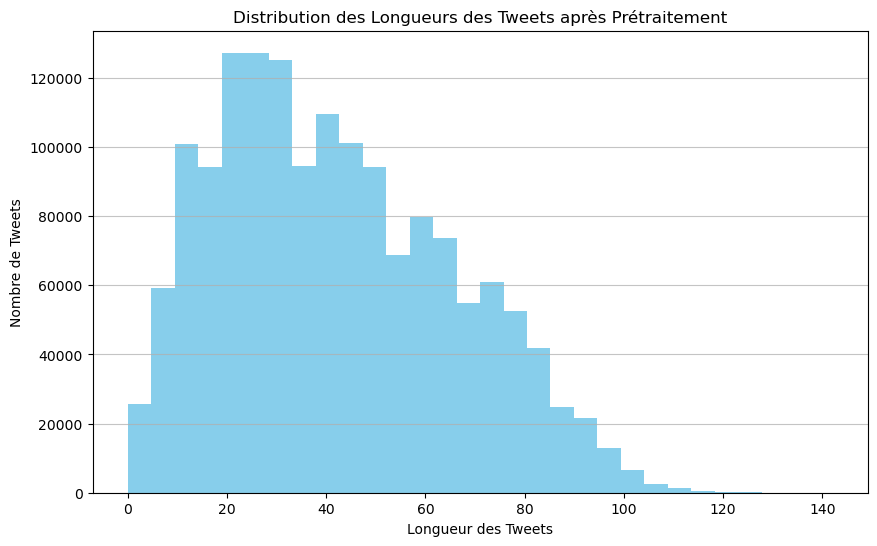

Nombre de textes vides après prétraitement : 7166


In [49]:
# Calcul de la longueur des textes lemmatisés
data_english_only['text_length'] = data_english_only['text_lemmatized'].apply(len)

# Affichage d'un histogramme des longueurs de texte
plt.figure(figsize=(10, 6))
plt.hist(data_english_only['text_length'], bins=30, color='skyblue')
plt.title('Distribution des Longueurs des Tweets après Prétraitement')
plt.xlabel('Longueur des Tweets')
plt.ylabel('Nombre de Tweets')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Vérification si certains textes sont vides
empty_texts = data_english_only['text_lemmatized'] == ''
print(f"Nombre de textes vides après prétraitement : {empty_texts.sum()}")

### modelisation avec lemmatisation

2024/06/09 18:37:35 INFO mlflow.tracking.fluent: Experiment with name 'Regression Logistique' does not exist. Creating a new experiment.


Meilleurs paramètres :  {'logisticregression__C': 1, 'logisticregression__penalty': 'l1', 'tfidfvectorizer__max_features': 5000}
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    156058
           1       0.76      0.80      0.78    156279

    accuracy                           0.78    312337
   macro avg       0.78      0.78      0.78    312337
weighted avg       0.78      0.78      0.78    312337



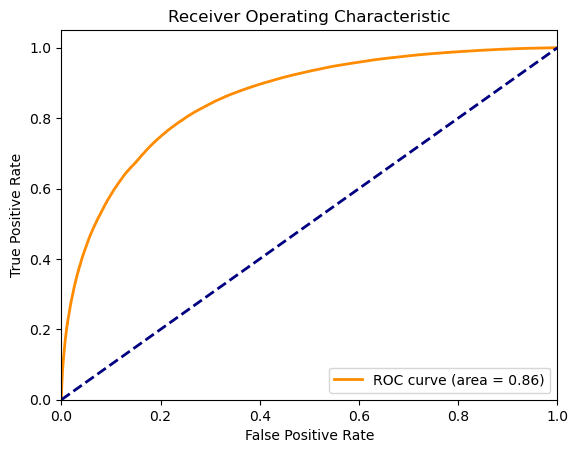

In [50]:
mlflow.set_experiment("Regression Logistique")

with mlflow.start_run(run_name="TF-IDF_Logistic_Regression_lemming"):
    # Séparation des données
    X_train, X_test, y_train, y_test = train_test_split(
        data_english_only['text_lemmatized'],
        data_english_only['target'],
        test_size=0.2,
        random_state=42
    )

    # Création d'un pipeline avec TF-IDF et régression logistique
    pipeline = make_pipeline(
        TfidfVectorizer(max_features=1000),
        LogisticRegression(solver='liblinear', max_iter=1000)
    )

    # Définition de la grille de paramètres pour la recherche
    param_grid = {
        'tfidfvectorizer__max_features': [1000, 5000],
        'logisticregression__C': [0.1, 1, 10],
        'logisticregression__penalty': ['l1', 'l2']
    }

    # Recherche d'hyperparamètres
    stratify = data_english_only['target']
    best_model = grid_search(pipeline, param_grid, X_train, y_train, stratify=stratify)

    # Entraînement et évaluation du meilleur modèle trouvé
    metrics = train_evaluate_model(best_model, X_train, y_train, X_test, y_test)
    
    # Enregistrement du modèle et des métriques
    mlflow.log_params(best_model.get_params())
    # Enregistrement des métriques
    mlflow.log_metrics(metrics)
    # Enregistrement du modèle
    mlflow.sklearn.log_model(best_model, 'TF-IDF Logistic Regression lemming')

    plot_roc_curve(best_model, X_test, y_test)
mlflow.end_run()

### les résultats :

- Precision pour la classe 0 (supposée être la classe négative) est de 0.79, ce qui signifie que 79 % des prédictions de la classe 0 étaient correctes.
- Recall pour la classe 0 est de 0.75, ce qui signifie que 75 % des instances réelles de la classe 0 ont été correctement prédites par le modèle.
- F1-score pour la classe 0 est de 0.77, ce qui est une moyenne harmonique entre la précision et le rappel, fournissant une mesure unique de la performance du modèle pour cette classe.

### De même, pour la classe 1 (supposée être la classe positive) :

- Precision est de 0.76, Recall est de 0.80, et F1-score est de 0.78.

- L'accuracy globale du modèle est de 78 %, ce qui signifie que le modèle a correctement prédit la classe de 78 % des tweets dans l'ensemble de test.
- Les scores macro avg et weighted avg fournissent des moyennes des métriques respectives sur les deux classes, tenant compte de l'équilibre ou du déséquilibre entre les classes.

### modelisation avec stemmatisation

In [51]:
# Convertir les listes de mots stemmés en chaînes de caractères
data_english_only['text_stemmed'] = data_english_only['text_stemmed'].apply(' '.join)


In [52]:
print(data_english_only['text_lemmatized'].head())

0        thats bummer shoulda got david carr third day
1    upset cant update facebook texting might cry r...
2      dived many time ball managed save rest go bound
3                      whole body feel itchy like fire
4                             behaving im mad cant see
Name: text_lemmatized, dtype: object


Meilleurs paramètres :  {'logisticregression__C': 1, 'logisticregression__penalty': 'l1', 'tfidfvectorizer__max_features': 5000}
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    156058
           1       0.76      0.80      0.78    156279

    accuracy                           0.77    312337
   macro avg       0.77      0.77      0.77    312337
weighted avg       0.77      0.77      0.77    312337



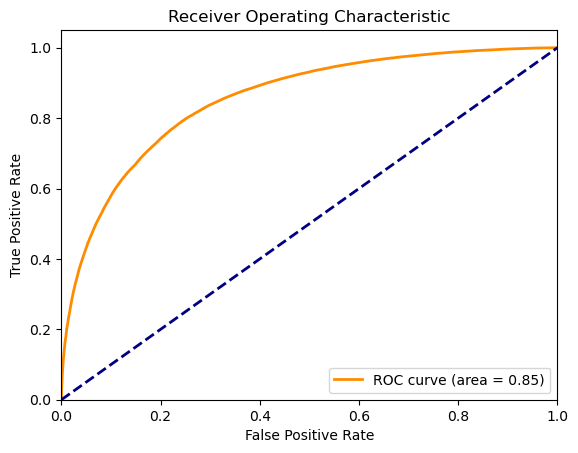

In [53]:
mlflow.set_experiment("Regression Logistique")

with mlflow.start_run(run_name="TF-IDF_Logistic_Regression_stemming"):
    # Séparation des données
    X_train, X_test, y_train, y_test = train_test_split(
        data_english_only['text_stemmed'],
        data_english_only['target'],
        test_size=0.2,
        random_state=42
    )

    # Création d'un pipeline avec TF-IDF et régression logistique
    pipeline = make_pipeline(
        TfidfVectorizer(max_features=1000),
        LogisticRegression(solver='liblinear', max_iter=1000)
    )

    # Définition de la grille de paramètres pour la recherche
    param_grid = {
        'tfidfvectorizer__max_features': [1000, 5000],
        'logisticregression__C': [0.1, 1, 10],
        'logisticregression__penalty': ['l1', 'l2']
    }

    # Recherche d'hyperparamètres
    stratify = data_english_only['target']
    best_model = grid_search(pipeline, param_grid, X_train, y_train, stratify=stratify)

    # Entraînement et évaluation du meilleur modèle trouvé
    metrics = train_evaluate_model(best_model, X_train, y_train, X_test, y_test)


    # Enregistrement du modèle et des métriques
    mlflow.log_params(best_model.get_params())
    # Enregistrement des métriques
    mlflow.log_metrics(metrics)
    # Enregistrement du modèle
    mlflow.sklearn.log_model(best_model, 'TF-IDF Logistic Regression stemming')

    plot_roc_curve(best_model, X_test, y_test)
mlflow.end_run()


#### Pour la stemmatisation, les métriques sont les suivantes :

- un AUC de 0.85 pour la courbe ROC
- Precision pour la classe 0: 0.79
- Recall pour la classe 0: 0.75
- F1-score pour la classe 0: 0.77
- Precision pour la classe 1: 0.76
- Recall pour la classe 1: 0.79
- F1-score pour la classe 1: 0.78
- Accuracy globale: 77%

Pour la lemmatisation, les métriques sont les suivantes :

- un AUC de 0.85 pour la courbe ROC
- Precision pour la classe 0: 0.79
- Recall pour la classe 0: 0.75
- F1-score pour la classe 0: 0.77
- Precision pour la classe 1: 0.76
- Recall pour la classe 1: 0.80
- F1-score pour la classe 1: 0.78
- Accuracy globale: 78%

#### En comparant ces métriques :

- Accuracy: La lemmatisation donne une accuracy globalement 1% plus élevée que le stemming. Bien que la différence soit petite, cela pourrait signifier que la lemmatisation a été légèrement meilleure pour généraliser sur l'ensemble de test.

- Precision et Recall: La lemmatisation semble avoir un meilleur rappel pour la classe 1 que le stemming (0.80 contre 0.79), ce qui signifie qu'elle était meilleure pour identifier correctement les instances réelles de la classe positive. La précision est la même pour la classe 0 dans les deux méthodes, et légèrement inférieure pour la classe 1 avec le stemming.

- F1-Score: Pour les deux méthodes, le score F1 est identique pour la classe 0 et légèrement supérieur pour la classe 1 avec la lemmatisation. Cela indique que la lemmatisation peut être légèrement meilleure en termes d'équilibre entre la précision et le rappel pour la classe positive.

- AUC: les deux méthodes ont des performances comparables en termes de séparation des classes.

En conclusion, les résultats suggèrent que la lemmatisation a légèrement surpassé le stemming dans cet ensemble de données pour le modèle spécifique utilisé (régression logistique avec vectorisation TF-IDF).

### FastText

Le modèle FastText a été téléchargé et extrait dans fasttext_model.
              precision    recall  f1-score   support

           0       0.74      0.73      0.74    156058
           1       0.74      0.75      0.74    156279

    accuracy                           0.74    312337
   macro avg       0.74      0.74      0.74    312337
weighted avg       0.74      0.74      0.74    312337



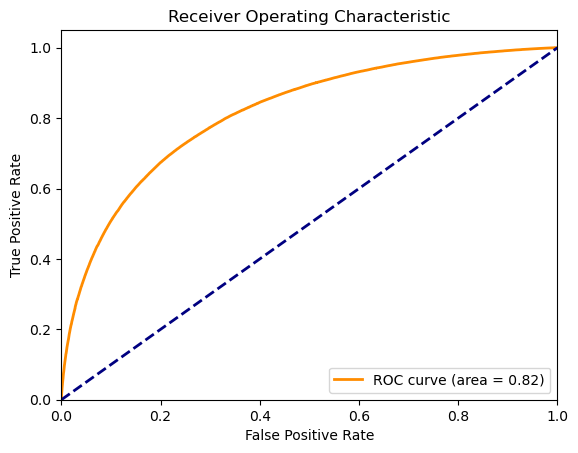

In [54]:
# Fonction pour télécharger FastText model s'il n'existe pas déjà
def download_fasttext_model(url, output_dir, model_file_name):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    model_path = os.path.join(output_dir, model_file_name)
    if not os.path.isfile(model_path):
        response = requests.get(url)
        with zipfile.ZipFile(BytesIO(response.content)) as model_zip:
            model_zip.extractall(output_dir)
        print(f"Le modèle FastText a été téléchargé et extrait dans {output_dir}.")
    else:
        print(f"Le modèle FastText est déjà disponible dans {output_dir}.")

# Fonction pour convertir les textes en vecteurs FastText moyens
def text_to_fasttext_vector(texts, model):
    vectors = []
    for text in texts:
        vector = np.mean(
            [model[word] for word in text if word in model.key_to_index] or
            [np.zeros(model.vector_size)],
            axis=0
        )
        vectors.append(vector)
    return np.array(vectors)

def vector_for_text(text, model):
    word_vectors = np.array([model[word] for word in text if word in model.key_to_index])
    if word_vectors.size:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

def text_to_fasttext_vector_parallel(texts, model):
    with ThreadPoolExecutor(max_workers=10) as executor:  # Ajustez max_workers selon vos ressources
        result_vectors = list(executor.map(lambda text: vector_for_text(text, model), texts))
    return np.array(result_vectors)

# Téléchargez le modèle FastText si nécessaire
fasttext_model_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"
fasttext_output_dir = "fasttext_model"
fasttext_model_file_name = "wiki-news-300d-1M.vec"
download_fasttext_model(fasttext_model_url, fasttext_output_dir, fasttext_model_file_name)

mlflow.set_experiment("Regression Logistique")

with mlflow.start_run(run_name="FastText_logistic_regression"):
    # Charger le modèle FastText
    fasttext_model_path = os.path.join(fasttext_output_dir, fasttext_model_file_name.replace('.zip', '.vec'))
    fasttext_model = KeyedVectors.load_word2vec_format(fasttext_model_path)

    # Continuez avec la séparation de données, l'entraînement et l'évaluation...
    X_train, X_test, y_train, y_test = train_test_split(
        data_english_only['text_lemmatized'].str.split().apply(lambda x: [word for word in x if word in fasttext_model.key_to_index]),
        data_english_only['target'],
        test_size=0.2,
        random_state=42
    )

    # Convertissez les textes en vecteurs
    X_train_vectors = text_to_fasttext_vector_parallel(X_train, fasttext_model)
    X_test_vectors = text_to_fasttext_vector_parallel(X_test, fasttext_model)

    # Créez et évaluez le modèle de régression logistique
    model = LogisticRegression(solver='liblinear', max_iter=1000)
    metrics = train_evaluate_model(model, X_train_vectors, y_train, X_test_vectors, y_test)

    # Enregistrement du modèle et des métriques
    mlflow.log_params(model.get_params())
    # Enregistrement des métriques
    mlflow.log_metrics(metrics)
    # Enregistrement du modèle
    mlflow.sklearn.log_model(model, 'FastText logistic regression')

    plot_roc_curve(model, X_test_vectors, y_test)
mlflow.end_run()


### Approche Modèle sur Mesure Avancé
Nous élaborerons ensuite un modèle plus complexe, utilisant des réseaux de neurones profonds, et comparerons les performances avec différents embeddings de mots.

In [15]:
def load_or_create_tokenizer(tokenizer_path, X_train):
    if os.path.exists(tokenizer_path):
        # Chargement du tokenizer existant
        with open(tokenizer_path, 'r') as handle:
            data = json.load(handle)
            tokenizer = tf.keras.preprocessing.text.Tokenizer()
            tokenizer.word_index = data['word_index']  # Restaurer l'index des mots
        print("Tokenizer chargé.")
    else:
        # Création et ajustement d'un nouveau tokenizer
        tokenizer = tf.keras.preprocessing.text.Tokenizer()
        tokenizer.fit_on_texts(X_train)
        # Sauvegarde du nouveau tokenizer
        with open(tokenizer_path, 'w') as handle:
            # Sauvegarde de l'index des mots dans un fichier JSON
            json.dump({'word_index': tokenizer.word_index}, handle)
        print("Nouveau tokenizer créé et sauvegardé.")
    return tokenizer

# Préparation des données
def prepare_data(data, model_name):
    # Encodage des labels
    label_encoder = LabelEncoder()
    data_labels = label_encoder.fit_transform(data['target'])

    # Division des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(
        data['text_lemmatized'], data_labels, test_size=0.2, random_state=42)

    # Chemin du fichier tokenizer
    tokenizer_path = f'../models/{model_name}_tokenizer.json'
    tokenizer = load_or_create_tokenizer(tokenizer_path, X_train)

    # Conversion des textes en séquences d'indices
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Padding des séquences pour qu'elles aient toutes la même longueur
    X_train_pad = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=100)
    X_test_pad = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=100)

    return np.array(X_train_pad, dtype=np.int32), np.array(X_test_pad, dtype=np.int32), y_train, y_test, tokenizer, X_train_seq, X_test_seq, X_train_pad, X_test_pad


def f1_score(precision, recall):
    return 2 * ((precision * recall) / (precision + recall + 1e-7))

class F1Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        precision = logs.get('val_precision')
        recall = logs.get('val_recall')
        f1 = f1_score(precision, recall)
        logs['val_f1'] = f1
        print(f" - val_f1: {f1:.4f}")
        mlflow.log_metrics({"val_f1": f1}, step=epoch)

def build_embedding_model(input_dim, output_dim, input_length):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, embeddings_initializer=GlorotUniform()),
        GlobalAveragePooling1D(),
        BatchNormalization(),
        Dense(10, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
    return model

def build_lstm_model(input_dim, output_dim, input_length):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=output_dim, embeddings_initializer=GlorotUniform()),
        LSTM(64, kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
    return model

def build_cnn_model(input_dim, output_dim, input_length):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, embeddings_initializer=GlorotUniform()),
        Conv1D(64, 5, activation='relu'),
        BatchNormalization(),
        GlobalMaxPooling1D(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
    return model

def train_and_save_model(xp_name, model_name, model, X_train, y_train, X_test, y_test, model_path, batch_size=32, epochs=10):
    mlflow.set_experiment(xp_name)
    
    with mlflow.start_run(run_name=model_name):
        mlflow.tensorflow.autolog(log_models=True)
        mlflow.log_params({"batch_size": batch_size, "epochs": epochs})
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
        model_checkpoint = ModelCheckpoint(filepath=model_path, save_best_only=True, monitor='val_loss', mode='min')
        f1_callback = F1Callback()
        
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size,
                            callbacks=[early_stopping, model_checkpoint, f1_callback])
        
        model.save(f'../models/{model_path}', save_format='tf')
        print("Modèle entraîné et sauvegardé.")
        
        best_epoch = early_stopping.stopped_epoch - 3
        best_val_loss = history.history['val_loss'][best_epoch]
        best_val_accuracy = history.history['val_accuracy'][best_epoch]
        mlflow.log_metrics({"best_val_loss": best_val_loss, "best_val_accuracy": best_val_accuracy})
        
def plot_roc_curve_tf(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_roc_curve_BERT(y_true, model, X_test):
    predictions = model.predict(X_test).logits
    y_scores = tf.nn.softmax(predictions, axis=-1)[:, 1].numpy()

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


#### Préparation des données
Nous commencerons par préparer les données, en les tokenisant et en les transformant en séquences numériques, puis en appliquant un padding pour assurer des longueurs uniformes.

In [8]:
tf.keras.backend.clear_session()  # Efface la session actuelle
# Préparation des données
X_train, X_test, y_train, y_test, tokenizer, X_train_seq, X_test_seq, X_train_pad, X_test_pad = prepare_data(data_english_only, 'embedding_model')

Tokenizer chargé.


#### Modèle de base TensorFlow/Keras avec Embedding

##### Entraînement du modèle
L'entraînement du modèle inclut l'utilisation d'un callback EarlyStopping pour éviter le surapprentissage.

In [9]:
# Paramètres de base pour les modèles
input_dim = len(tokenizer.word_index) + 1
output_dim = 50  # Dimension de sortie pour l'embedding
input_length = 100  # Longueur de l'input pour les modèles de réseau de neurones

# Construction et entraînement du modèle Embedding
embedding_model = build_embedding_model(input_dim, output_dim, input_length)
train_and_save_model("TensorFlow/Keras avec Embedding", "tf_keras_embedding",embedding_model, X_train_pad, y_train, X_test_pad, y_test, 'embedding_model.keras', batch_size=64)

Epoch 1/10


2024-06-10 07:41:21.969632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-06-10 07:41:21.999990: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


19522/19522 [==============================] - ETA: 0s - loss: 0.4744 - accuracy: 0.7718 - precision: 0.7699 - recall: 0.7744

2024-06-10 08:00:47.307086: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


 - val_f1: 0.7738


/opt/anaconda3/envs/bert_sentiment_analysis/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19522/19522 [==============================] - 1195s 61ms/step - loss: 0.4744 - accuracy: 0.7718 - precision: 0.7699 - recall: 0.7744 - val_loss: 0.4777 - val_accuracy: 0.7746 - val_precision: 0.7770 - val_recall: 0.7706 - val_f1: 0.7738
Epoch 2/10
19522/19522 [==============================] - 1159s 59ms/step - loss: 0.4353 - accuracy: 0.7969 - precision: 0.7973 - recall: 0.7954 - val_loss: 0.4977 - val_accuracy: 0.7774 - val_precision: 0.8221 - val_recall: 0.7083 - val_f1: 0.7610
Epoch 3/10
19522/19522 [==============================] - 1167s 60ms/step - loss: 0.4128 - accuracy: 0.8104 - precision: 0.8118 - recall: 0.8074 - val_loss: 0.5944 - val_accuracy: 0.7486 - val_precision: 0.6933 - val_recall: 0.8923 - val_f1: 0.7803
Epoch 4/10
19522/19522 [==============================] - 1167s 60ms/step - loss: 0.3928 - accuracy: 0.8234 - precision: 0.8252 - recall: 0.8199 - val_loss: 0.6958 - val_accuracy: 0.6880 - val_precision: 0.6261 - val_recall: 0.9346 - val_f1: 0.7498
Epoch 4: early 

2024-06-10 08:59:20.555363: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2024/06/10 08:59:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/bert_sentiment_analysis/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils."


Modèle entraîné et sauvegardé.


##### Tracé de la courbe ROC

9761/9761 [==============================] - 13s 1ms/step


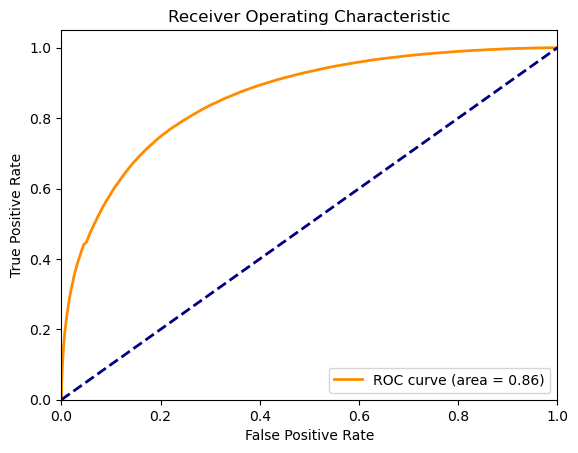

In [10]:
# Prédictions et courbe ROC
y_pred_proba = embedding_model.predict(X_test_pad).ravel()
plot_roc_curve_tf(y_test, y_pred_proba)

#### Modèle TensorFlow/Keras avec Embedding et couche LSTM

#### Préparation des données
Nous commencerons par préparer les données, en les tokenisant et en les transformant en séquences numériques, puis en appliquant un padding pour assurer des longueurs uniformes.

In [11]:
tf.keras.backend.clear_session()  # Efface la session actuelle
# Préparation des données
X_train, X_test, y_train, y_test, tokenizer, X_train_seq, X_test_seq, X_train_pad, X_test_pad = prepare_data(data_english_only, 'lstm_model')

Nouveau tokenizer créé et sauvegardé.


##### Entraînement du modèle
L'entraînement du modèle inclut l'utilisation d'un callback EarlyStopping pour éviter le surapprentissage.

In [16]:
# Entraînement du modèle LSTM
model_lstm = build_lstm_model(input_dim, 100, 100)
train_and_save_model("TensorFlow/Keras avec Embedding et couche LSTM", "tf_keras_embedding_LSTM",model_lstm, X_train, y_train, X_test, y_test, 'lstm_model.keras', batch_size=64)

Epoch 1/10


2024-06-10 09:56:41.126676: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


19522/19522 [==============================] - ETA: 0s - loss: 0.4795 - accuracy: 0.7765 - precision: 0.7760 - recall: 0.7767

2024-06-10 10:29:34.264129: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


 - val_f1: 0.7933


/opt/anaconda3/envs/bert_sentiment_analysis/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19522/19522 [==============================] - 2034s 104ms/step - loss: 0.4795 - accuracy: 0.7765 - precision: 0.7760 - recall: 0.7767 - val_loss: 0.4585 - val_accuracy: 0.7850 - val_precision: 0.7640 - val_recall: 0.8250 - val_f1: 0.7933
Epoch 2/10
19522/19522 [==============================] - 2032s 104ms/step - loss: 0.4376 - accuracy: 0.7995 - precision: 0.8002 - recall: 0.7975 - val_loss: 0.4552 - val_accuracy: 0.7894 - val_precision: 0.7878 - val_recall: 0.7926 - val_f1: 0.7902
Epoch 3/10
19522/19522 [==============================] - 1927s 99ms/step - loss: 0.4198 - accuracy: 0.8102 - precision: 0.8104 - recall: 0.8092 - val_loss: 0.4583 - val_accuracy: 0.7883 - val_precision: 0.7799 - val_recall: 0.8039 - val_f1: 0.7917
Epoch 4/10
15186/19522 [======================>.......] - ETA: 25:31 - loss: 0.4025 - accuracy: 0.8203 - precision: 0.8205 - recall: 0.8194

##### Tracé de la courbe ROC

In [ ]:
# Prédictions et courbe ROC
y_pred_proba = model_lstm.predict(X_test_pad).ravel()
plot_roc_curve_tf(y_test, y_pred_proba)

#### Modèle TensorFlow/Keras avec Embedding et Convolutional Neural Network (CNN)

#### Préparation des données
Nous commencerons par préparer les données, en les tokenisant et en les transformant en séquences numériques, puis en appliquant un padding pour assurer des longueurs uniformes.

In [ ]:
tf.keras.backend.clear_session()  # Efface la session actuelle
# Préparation des données
X_train, X_test, y_train, y_test, tokenizer, X_train_seq, X_test_seq, X_train_pad, X_test_pad = prepare_data(data_english_only, 'cnn_model')

Nouveau tokenizer créé et sauvegardé.


##### Entraînement du modèle
Nous utiliserons l'arrêt précoce pour éviter le surajustement pendant l'entraînement.

In [ ]:
# Paramètres de base pour les modèles
input_dim = len(tokenizer.word_index) + 1
output_dim = 50  # Dimension de sortie pour l'embedding
input_length = 100  # Longueur de l'input pour les modèles de réseau de neurones
# Entraînement du modèle CNN
model_cnn = build_cnn_model(input_dim, 100, 100)
train_and_save_model("TensorFlow/Keras avec Embedding et Convolutional Neural Network (CNN)", "tf_keras_embedding_CNN",model_cnn, X_train, y_train, X_test, y_test, 'cnn_model.keras', batch_size=64, epochs=3)

##### Tracé de la courbe ROC

In [ ]:
# Prédictions et courbe ROC
y_pred_proba = model_cnn.predict(X_test_pad).ravel()
plot_roc_curve_tf(y_test, y_pred_proba)

#### Préparation des données
Nous commencerons par préparer les données, en les tokenisant et en les transformant en séquences numériques, puis en appliquant un padding pour assurer des longueurs uniformes.

In [ ]:
tf.keras.backend.clear_session()  # Efface la session actuelle
# Préparation des données
X_train, X_test, y_train, y_test, tokenizer, X_train_seq, X_test_seq, X_train_pad, X_test_pad = prepare_data(data_english_only, 'bert_model')

### BERT

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Mettre le modèle en mode évaluation
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2]}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = inputs['labels'].cpu().numpy()

            predictions.extend(preds)
            true_labels.extend(labels)

    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')
    cm = confusion_matrix(true_labels, predictions)

    return precision, recall, f1, cm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Cette fonction affiche la matrice de confusion.
    La normalisation peut être ajoutée en fixant `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in enumerate(np.ndindex(cm.shape)):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Configuration du modèle BERT pour le fine-tuning
Configurez le modèle BERT pour le fine-tuning avec les données chargées :


In [ ]:
import ast
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall
import os
import time
import mlflow

# Définir l'expérience MLflow
mlflow.set_experiment('BERT')
# MLflow tracking
mlflow.tensorflow.autolog()

with mlflow.start_run(run_name="BERT"):
    # Chargement des données
    data_english_only = pd.read_csv('../data/data_english_only.csv')

    # Conversion des chaînes de caractères représentant des listes en listes Python réelles
    data_english_only['text_lemmatized'] = data_english_only['text_lemmatized'].apply(ast.literal_eval)

    # Reconstruction des textes lemmatisés en une seule chaîne de caractères pour chaque exemple
    texts = data_english_only['text_lemmatized'].apply(' '.join)

    # Labels de sentiment
    labels = data_english_only['target'].values

    # Initialisation du tokenizer TinyBERT
    tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')

    # Tokenisation des textes
    encodings = tokenizer(texts.tolist(), truncation=True, padding='max_length', max_length=128, return_tensors='tf')

    # Convertir les tenseurs en tableaux NumPy
    input_ids = encodings['input_ids'].numpy()
    attention_masks = encodings['attention_mask'].numpy()

    # Division en train et test avec stratification
    train_input_ids, val_input_ids, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.1, stratify=labels)
    train_attention_masks, val_attention_masks = train_test_split(attention_masks, test_size=0.1, stratify=labels)

    # Convertir les tableaux NumPy en tenseurs TensorFlow
    train_input_ids = tf.convert_to_tensor(train_input_ids)
    val_input_ids = tf.convert_to_tensor(val_input_ids)
    train_attention_masks = tf.convert_to_tensor(train_attention_masks)
    val_attention_masks = tf.convert_to_tensor(val_attention_masks)
    train_labels = tf.convert_to_tensor(train_labels)
    val_labels = tf.convert_to_tensor(val_labels)

    # Création des DataLoaders
    batch_size = 64
    train_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': train_input_ids, 'attention_mask': train_attention_masks}, train_labels)).shuffle(len(train_input_ids)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': val_input_ids, 'attention_mask': val_attention_masks}, val_labels)).batch(batch_size)

    # Initialisation du modèle TinyBERT
    model = TFBertForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', num_labels=2, from_pt=True)

    # Utiliser l'optimiseur legacy.Adam pour meilleure performance sur M1/M2
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=2e-5)

    # Compiler le modèle avec la fonction de perte appropriée et les métriques
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy', Precision(), Recall()])

    # Vérifier si un checkpoint existe
    checkpoint_path = "checkpoints"
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_path)

    if latest_checkpoint:
        model.load_weights(latest_checkpoint)
        print(f"Resuming from checkpoint {latest_checkpoint}")

    # Entraînement du modèle
    epochs = 3
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_freq='epoch')

    for epoch in range(epochs):
        history = model.fit(train_dataset, validation_data=val_dataset, epochs=1, callbacks=[checkpoint_callback])

        # Log des métriques dans MLflow
        mlflow.log_metrics({"loss": history.history['loss'][0], "accuracy": history.history['accuracy'][0], "precision": history.history['precision'][0], "recall": history.history['recall'][0]}, step=epoch)
        mlflow.log_metrics({"val_loss": history.history['val_loss'][0], "val_accuracy": history.history['val_accuracy'][0], "val_precision": history.history['val_precision'][0], "val_recall": history.history['val_recall'][0]}, step=epoch)

        print(f"End of epoch {epoch+1}, pausing for 2 minutes.")
        time.sleep(120)

    output_dir = "../models/finetuned_bert_fr/"
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    mlflow.end_run()
